In [18]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Preprocess the dataset i.e load the dataset

In [10]:
train_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train"
test_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Test"

In [11]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [12]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [16]:
BATCH_SIZE = 32 

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f25a452d050>,
 ['Fake', 'Real'])

torch.Size([3, 224, 224]) tensor(1)


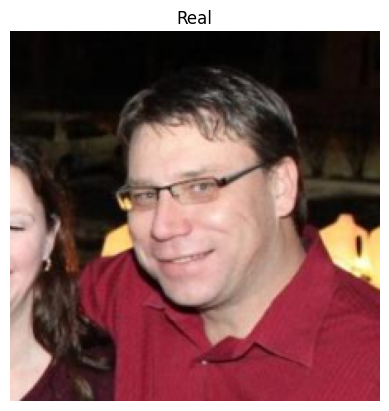

In [24]:

image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
print(image.shape, label)

# Plot image
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);

## Divide Images into patches

In [42]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels=3, # RGB image i.e 3 channels
                 patch_size=16, # image divided into 16x16 patches
                 embedding_dim=768,   # 16 * 16 * 3 i.e patch_size * patch_size * channels
                 img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.img_size = img_size
        # create patches using conv2d layer
        self.proj = nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
        
        # Flatten each patch to a vector
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)  # (B, D, H/P, W/P) → (B, D, N)
        
        # Number of patches
        num_patches = (img_size // patch_size) ** 2
        
        # Create a learnable [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        
        # Learnable positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))
    
    def forward(self, x):
        B = x.size(0)
        assert self.img_size % self.patch_size == 0, "Image size must be divisible by patch size"
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B, N, D)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, D)
        x += self.pos_embedding
        return x

In [43]:
# testing PatchEmbeddings function on single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
      
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 197, 768])


In [44]:
# View the patch embedding and patch embedding shape

print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-0.7500,  0.7134, -1.1710,  ..., -0.2890, -2.2428, -0.6855],
         [-1.6143, -0.3279, -1.4348,  ...,  1.8129,  0.4904,  0.0533],
         ...,
         [ 0.8483,  0.7974,  0.1425,  ..., -0.2846,  1.0491,  0.8525],
         [-0.4763, -0.5388, -0.3553,  ..., -0.3035,  0.1318,  1.5288],
         [-0.6623, -0.0348,  1.4799,  ..., -0.2414,  1.3680, -0.1421]]],
       grad_fn=<AddBackward0>)
Patch embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 attn_dropout:float=0): 
        super().__init__()
        
        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 
        
    # Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [46]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, 
                 mlp_size:int=3072, # MLP size
                 dropout:float=0.1): # Dropout
        super().__init__()
        
        # Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

## Combine our custom layers into one transformer Encoder

In [47]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # MSA block 
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # MLP block 
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
         
    def forward(self, x):
        x =  self.msa_block(x) + x 
        x = self.mlp_block(x) + x 
        
        return x

In [48]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [49]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224, # Training resolution
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Number of transformer layers
                 embedding_dim:int=768, # Embedding dimension
                 mlp_size:int=3072, # MLP size
                 num_heads:int=12, # Number of attention heads
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Number of classes for classification
        super().__init__()
        
        # Ensure the image size is divisible by patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # Calculate number of patches
        self.num_patches = (img_size * img_size) // patch_size**2
        
        #Patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim,
                                              img_size=img_size)
        
        # Transformer Encoder blocks
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])  # The class token is at the 0th index

        return x


In [50]:
# Create an instance of ViT 
vit = ViT(num_classes=len(class_names))

In [63]:
import torch
from tqdm import tqdm  # Import tqdm for the progress bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit.to(device)

optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3,  # Learning rate
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

# Training loop
import torch
from tqdm import tqdm

def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, device):
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training phase
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update training loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # Average training loss and accuracy
        train_loss /= len(train_loader)
        train_acc = correct_train / total_train

        # Evaluation phase
        model.eval()  # Set model to evaluation mode
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Update test loss and accuracy
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        # Average test loss and accuracy
        test_loss /= len(test_loader)
        test_acc = correct_test / total_test

        # Print epoch results
        print(f'Epoch: {epoch + 1} | '
              f'train_loss: {train_loss:.4f} | '
              f'train_acc: {train_acc:.4f} | '
              f'test_loss: {test_loss:.4f} | '
              f'test_acc: {test_acc:.4f}')

train_model(vit, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=10, device=device)

Epoch: 1 | train_loss: 0.6934 | train_acc: 0.5013 | test_loss: 0.6933 | test_acc: 0.4964


Epoch: 2 | train_loss: 0.6936 | train_acc: 0.4995 | test_loss: 0.6932 | test_acc: 0.4964


Epoch: 3 | train_loss: 0.6935 | train_acc: 0.5013 | test_loss: 0.6931 | test_acc: 0.5036


Epoch: 4 | train_loss: 0.6934 | train_acc: 0.5048 | test_loss: 0.6932 | test_acc: 0.5036


Epoch: 5 | train_loss: 0.6935 | train_acc: 0.4990 | test_loss: 0.6931 | test_acc: 0.4964


KeyboardInterrupt: 